# EDA

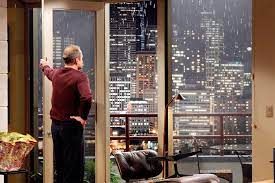

In [33]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Stakeholder
Timothy Stevens: Owns expensive houses in the center, needs to get rid, best timing within a year, open for renovation when profits rise.

# Import the data

In [34]:
df = pd.read_csv("data/King_County_House_prices_dataset.csv")

# Understanding the data


In [35]:
df.info()
# waterfront and yr_renovated contain NAs
# date needs to be converted
# Better description of columns can be found here: https://geodacenter.github.io/data-and-lab/KingCounty-HouseSales2015/
# Info on Zipcodes: https://gis-kingcounty.opendata.arcgis.com/datasets/zipcodes-for-king-county-and-surrounding-area-shorelines-zipcode-shore-area/explore?location=47.504243%2C-121.477600%2C8.67
# sqft_living15 is the avarage size of living space of the closest 15 neighbours. Will help to determine if a house is bigger compared to neighbors.
# view - An index from 0 to 4 of how good the view of the property was
#condition - An index from 1 to 5 on the condition of the apartment,
#grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

# Research questions + hypotheses and Todo
Stakeholder: Timothy Stevens: Owns expensive houses in the center, needs to get rid, best timing within a year, open for renovation when profits rise.

Question: When is the best timing to sell houses?
Hypothesis: The avarage price varies over the year

Question: Will a recent renovation increase the selling price?
Hypothesis: Houses renovated in the same year have a higher avarage price.

Hypothesis: There is a correlation between grade and price, sqft_living and price.
Hypothesis: View, grade and condition are positively correlated.

For the EDA:
1. Filter for houses in the center (by zipcode?). What is the center? Seattle?
2. Define 'expensive' (80% quartile?). 




# Data exploration

In [36]:
#df.hist(column=["price","bedrooms","sqft_living","floors","grade","yr_built","yr_renovated","sqft_living15"],layout=(4,2),figsize=(12,6))

# There are a few very big very very expensive houses
# Filter them for a first glance

#df[df.price < 4000000].hist(column=["price","bedrooms","sqft_living","floors","grade","yr_built","yr_renovated","sqft_living15"],layout=(4,2),figsize=(12,6))

# There seem to be some houses that are very high cost and/or high number of bedrooms, very high number of sqft_living. Maybe outliers? need to check.
# Most houses have not been renovated which is sometimes a 0 and sometimes NaN !

df[df.price > 7000000]
# 45 houses over 3 million
# 2 houses over 7 million

df[df.bedrooms > 10]
# 2 houses with more than 10 bedrooms, 33 bedrooms one is probably a typo because it is not too big.

df[df.sqft_living > 8000]
# 211 houses with over 5k sqft living
# 9 houses with over 8k sqft living. all with high grade and a high price so probably valid data.




,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1162,1247600105,10/20/2014,5110000.000,5,5.250,8010,45517,2.000,1.000,4.000,...,12,5990,2020.0,1999,0.000,98033,47.677,-122.211,3430,26788
3910,9808700762,6/11/2014,7060000.000,5,4.500,10040,37325,2.000,1.000,2.000,...,11,7680,2360.0,1940,2001.000,98004,47.650,-122.214,3930,25449
4407,2470100110,8/4/2014,5570000.000,5,5.750,9200,35069,2.000,0.000,0.000,...,13,6200,3000.0,2001,NaN,98039,47.629,-122.233,3560,24345
7245,6762700020,10/13/2014,7700000.000,6,8.000,12050,27600,2.500,0.000,3.000,...,13,8570,3480.0,1910,1987.000,98102,47.630,-122.323,3940,8800
8085,1924059029,6/17/2014,4670000.000,5,6.750,9640,13068,1.000,1.000,4.000,...,12,4820,4820.0,1983,2009.000,98040,47.557,-122.210,3270,10454
9245,9208900037,9/19/2014,6890000.000,6,7.750,9890,31374,2.000,0.000,4.000,...,13,8860,1030.0,2001,0.000,98039,47.630,-122.240,4540,42730
12764,1225069038,5/5/2014,2280000.000,7,8.000,13540,307752,3.000,0.000,4.000,...,12,9410,4130.0,1999,0.000,98053,47.667,-121.986,4850,217800
14542,2303900035,6/11/2014,2890000.000,5,6.250,8670,64033,2.000,0.000,4.000,...,13,6120,2550.0,1965,NaN,98177,47.730,-122.372,4140,81021
18288,6072800246,7/2/2014,3300000.000,5,6.250,8020,21738,2.000,0.000,0.000,...,11,8020,0.0,2001,NaN,98006,47.568,-122.189,4160,18969


In [37]:
# Zip codes for seattle
#sorted(df.zipcode.unique())

# Seattle Zipcodes range from 98101-98199 (only 64 are taken)(https://www.zipcode.com.ng/2022/12/seattle-zip-codes-wa.html)

df["seattle"] = df.zipcode.between(98101,98200)
df.groupby("seattle").mean()

# Interestingly the avarage price does not differ, but houses within Seattle are smaller, with fewer bed and bathrooms and the lot is much smaller.




,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
seattle,,,,,,,,,,,,,,,,,,,
False,4564301555.562,544000.476,3.517,2.273,2282.881,21243.162,1.518,0.007,0.185,3.389,7.885,2034.131,1982.403,53.770,98038.370,47.522,-122.130,2202.569,17432.359
True,4603227499.785,535085.600,3.171,1.894,1795.344,6455.840,1.461,0.008,0.302,3.439,7.339,1443.158,1954.956,126.144,98133.639,47.613,-122.332,1682.805,6182.386


# Correlations


,price
price,1.000
bedrooms,0.309
bathrooms,0.526
sqft_living,0.702
sqft_lot,0.090
floors,0.257
view,0.396
condition,0.036
grade,0.668
sqft_above,0.605


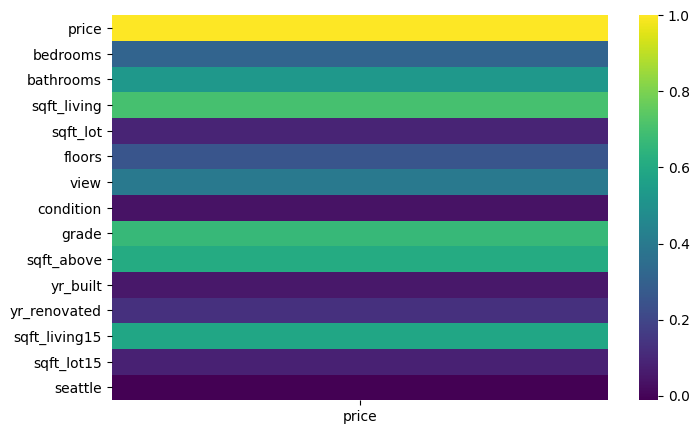

In [55]:
# 1. condition, view and grade
df[["grade","view","condition","seattle"]].groupby("seattle").corr()
# Grade and view are marginally correlated, but condition isn't. Might be worth to deepdive in what exactly they mean.
# View = quality der Besichtigung???
# Grade = How well is it constructed?
# Condition = Wie gut ist es in Schuss?!

# What influences the price?
df[["grade","view","condition","seattle"]].groupby("seattle").corr()
corr_mat_price = df.drop(["id","date","waterfront","zipcode","lat","long","seattle"],axis=1).corr()
sns.heatmap(corr_mat_price[["price"]], cmap="viridis")
corr_mat_price[["price"]]
# Factors influencing the price (> 50%)
# Bathrooms, sqft-living, grade, sqft_above, sqft_living15
# However, yr_renovated doesnt make sense without changing it!!!
